# Birds
## How to use this notebook
### Imports
TODO: Write which packages the user has to import to use this notebook. Something like:
> pip install pandas matplotlib numpy seaborn basemap etc..

### Data
In order to run this notebook you must first extract `birds.csv` from `birds.zip`

In [101]:
# TODO: Cleanup imports that are not needed
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import plotly.express as px
import itertools
import collections
import json
import nltk
from nltk.corpus import stopwords
# from dwca.read import DwCAReader
from mpl_toolkits.basemap import Basemap
from IPython.display import display
import re
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

## Importing data
We start by reading the file to a dataframe:

In [102]:
birds = pd.read_csv("birds.csv", index_col=False)
display(birds.head())
print("Number of rows:", birds.shape[0])

,vernacularName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory
0,Lesser Black-backed Gull,Larus fuscus,Charadriiformes,Laridae,Larus,fuscus,2016-05-31T00:00:00,2016,5,31,Suðurland,Heimaey--Víkin,63.408356,-20.280504,1.0,LC
1,Ruddy Turnstone,Arenaria interpres,Charadriiformes,Scolopacidae,Arenaria,interpres,2004-09-17T00:00:00,2004,9,17,Suðurnes,Garður,64.072426,-22.660074,NaN,LC
2,Glaucous Gull,Larus hyperboreus,Charadriiformes,Laridae,Larus,hyperboreus,2010-11-24T00:00:00,2010,11,24,Norðurland eystra,Húsavík--hafnarsvæði (harbour area),66.044800,-17.349987,NaN,LC
3,Eurasian Wigeon,Mareca penelope,Anseriformes,Anatidae,Anas,penelope,2018-06-24T00:00:00,2018,6,24,Suðurland,"(63.6731,-20.3561)",63.673130,-20.356092,2.0,LC
4,Mallard,Anas platyrhynchos,Anseriformes,Anatidae,Anas,platyrhynchos,2020-02-29T00:00:00,2020,2,29,Vestfirðir,Bolungarvik--hafnarsvaedi (harbour area),66.157510,-23.244152,11.0,LC


Number of rows: 751153


Most of these columns are self-explanatory but there are a couple of things we want to clear up.

`verbatimScientificName` is the [binomial name](https://en.wikipedia.org/wiki/Binomial_nomenclature) of the species. This is also the same as the columns `genus`+ `specificEpithet`. 

Regarding the [taxonomic rank](https://en.wikipedia.org/wiki/Taxonomic_rank), we only include `order`, `family`, `genus` and `specificEpithet` and exclude `kingdom`, `phylum` and `class`, since these fields would be identical for all records (*Animalia*, *Chordata* and *Aves*)

The column `individualCount` says how many birds of the given species were spotted at the given time and location.

`iucnRedListCategory` is the [conservation status](https://www.iucnredlist.org/) of the species.

![](images/Status_iucn3.1.svg.png)

## Cleaning data
There are a couple of duplicated rows which we can remove:

TODO: Perhaps show some duplicated rows

In [103]:
print("Number of rows:", birds.shape[0])

dupes = birds[birds.duplicated(keep=False)]
dupes = dupes.sort_values(by=["vernacularName"])
display(dupes[["vernacularName","individualCount", "eventDate", "locality"]].head())

birds = birds.drop_duplicates()
print("Number of rows:", birds.shape[0])

Number of rows: 751153


,vernacularName,individualCount,eventDate,locality
489067,Alder Flycatcher,1.0,2020-09-21T00:00:00,Sólveigarlundur
8208,Alder Flycatcher,1.0,2003-10-10T00:00:00,Eyjafjöll--Kverkin
498121,Alder Flycatcher,1.0,2020-09-21T00:00:00,Miðnes--Hvalsnes
176514,Alder Flycatcher,1.0,2020-09-23T00:00:00,Miðnes--Hvalsnes
212790,Alder Flycatcher,1.0,2020-09-21T00:00:00,Miðnes--Hvalsnes


Number of rows: 655657


There are some rows where `individualCount` is NaN. We think it's safe to replace these values with 1.

TODO: Rationalize why we think we can replace theses values. Similar case here: https://github.com/nmtarr/wildlife-wrangler/blob/master/wrangler_functions.py#L443

In [104]:
print("Before")
display(birds[["vernacularName","individualCount"]].head())
birds["individualCount"] = birds["individualCount"].fillna(value=1)
print("After")
display(birds[["vernacularName","individualCount"]].head())

Before


,vernacularName,individualCount
0,Lesser Black-backed Gull,1.0
1,Ruddy Turnstone,NaN
2,Glaucous Gull,NaN
3,Eurasian Wigeon,2.0
4,Mallard,11.0


After


,vernacularName,individualCount
0,Lesser Black-backed Gull,1.0
1,Ruddy Turnstone,1.0
2,Glaucous Gull,1.0
3,Eurasian Wigeon,2.0
4,Mallard,11.0


In [105]:
# Not sure if this should be included in the final product
# but it is helpful to have a list of bird names

# Unique bird species
bird_names = birds["vernacularName"].unique().tolist()
bird_names.sort()
for name in bird_names:
    print(name)

print("Number of unique bird species:", len(bird_names))

Acadian Flycatcher
Alder Flycatcher
Alpine Swift
American Black Duck
American Coot
American Golden-Plover
American Pipit
American Redstart
American Robin
American Wigeon
Arctic Loon
Arctic Tern
Arctic Warbler
Atlantic Puffin
Baird's Sandpiper
Baltimore Oriole
Bank Swallow
Bar-headed Goose
Bar-tailed Godwit
Barn Swallow
Barnacle Goose
Barred Warbler
Barrow's Goldeneye
Belted Kingfisher
Black Guillemot
Black Kite
Black Redstart
Black Scoter
Black Stork
Black Swan
Black Tern
Black-and-white Warbler
Black-bellied Plover
Black-crowned Night-Heron
Black-headed Gull
Black-legged Kittiwake
Black-tailed Godwit
Black-throated Blue Warbler
Black-throated Green Warbler
Black-throated Thrush
Black-winged Stilt
Blackpoll Warbler
Blue-winged Teal
Bluethroat
Blyth's Reed Warbler
Bohemian Waxwing
Bonaparte's Gull
Brambling
Brant
Broad-billed Sandpiper
Buff-breasted Sandpiper
Bufflehead
Cackling Goose
Canada Goose
Canada Warbler
Carrion Crow
Caspian Gull
Cattle Egret
Cedar Waxwing
Cerulean Warbler
Citri

## Icelandic names and rarity
We made a `.csv` file for the species above that had the columns `vernacularName` and `verbatimScientificName`.

We added two columns to this `.csv` file: `icelandicName` and `rarity`.
The Icelandic names were manually looked up on [eBird](https://ebird.org/).

The rarity was found on a [List of Icelandic Bird Species](https://notendur.hi.is/yannk/1111.pdf) from the University of Iceland. Species with an `"F"` in the 6th column are considered rare in Iceland.

Here we import our `.csv` file:

In [106]:
bird_names_and_rarity = pd.read_csv("bird_names_and_rarity.csv", index_col=False)
# Note: We remove the verbatimScientificName column to prepare the join with the birds dataframe below
bird_names_and_rarity.drop(["verbatimScientificName"], axis=1, inplace=True)
display(bird_names_and_rarity.head())

,vernacularName,icelandicName,rare
0,Common Redpoll,Auðnutittlingur,NaN
1,Hoary Redpoll,Hrímtittlingur,F
2,Eurasian Sparrowhawk,Sparrhaukur,F
3,Paddyfield Warbler,Dvalsöngvari,F
4,Blyth's Reed Warbler,Elrisöngvari,F


We want the values in the `rare` column to be more descriptive so we replace `F` with `True` and `NaN` with `False`.

We also drop the `verbatimScientificName` to prepare the merge with the `birds` dataframe.

In [107]:
bird_names_and_rarity["rare"] = bird_names_and_rarity["rare"].replace("F", True)
bird_names_and_rarity["rare"] = bird_names_and_rarity["rare"].fillna(False)
display(bird_names_and_rarity.head())

,vernacularName,icelandicName,rare
0,Common Redpoll,Auðnutittlingur,False
1,Hoary Redpoll,Hrímtittlingur,True
2,Eurasian Sparrowhawk,Sparrhaukur,True
3,Paddyfield Warbler,Dvalsöngvari,True
4,Blyth's Reed Warbler,Elrisöngvari,True


We can now merge the dataframe `bird_names_and_rarity` with our main dataframe, `birds`.

In [108]:
# NOTE: Do not run this cell more than once.
#       Doing so will result in multiple icelandicName and rare columns in birds
birds = pd.merge(birds, bird_names_and_rarity, how="inner", on="vernacularName")

In [109]:
birds = birds.sample(frac=1).reset_index(drop=True) # This randomly shuffles the rows, to make the output look more interesting 
display(birds.head())

,vernacularName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory,icelandicName,rare
0,Barrow's Goldeneye,Bucephala islandica,Anseriformes,Anatidae,Bucephala,islandica,2015-04-09T00:00:00,2015,4,9,Norðurland eystra,Mývatn--Reykjahlíð (bay),65.641530,-16.916412,3.0,LC,Húsönd,False
1,Northern Wheatear,Oenanthe oenanthe,Passeriformes,Muscicapidae,Oenanthe,oenanthe,2019-05-08T00:00:00,2019,5,8,Norðurland vestra,"560, Sveitarfélagið Skagafjörður IS-Northwest ...",65.648420,-19.443870,1.0,LC,Steindepill,False
2,Common Scoter,Melanitta nigra,Anseriformes,Anatidae,Melanitta,nigra,2019-12-07T00:00:00,2019,12,7,Austurland,"Þvottá, sjór, IS (64,509, -14,478)",64.508770,-14.478482,30.0,LC,Hrafnsönd,False
3,Graylag Goose,Anser anser,Anseriformes,Anatidae,Anser,anser,2014-05-28T00:00:00,2014,5,28,Vestfirðir,Bolungarvik--Sydradalsvatn,66.128365,-23.242435,2.0,LC,Grágæs,False
4,Gray Heron,Ardea cinerea,Pelecaniformes,Ardeidae,Ardea,cinerea,2003-02-28T00:00:00,2003,2,28,Norðurland eystra,Kaldbakstjarnir,66.021540,-17.367798,1.0,LC,Gráhegri,True


Here we reorder the columns to put `icelandicName` in the second column. 

In [110]:
reordered_cols = [
    'vernacularName',
    'icelandicName',
    'verbatimScientificName',
    'order',
    'family',
    'genus',
    'specificEpithet',
    'eventDate',
    'year',
    'month',
    'day',
    'stateProvince',
    'locality',
    'decimalLatitude',
    'decimalLongitude',
    'individualCount',
    'iucnRedListCategory',
    'rare'
    ]
birds = birds[reordered_cols]
display(birds.head())

,vernacularName,icelandicName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory,rare
0,Barrow's Goldeneye,Húsönd,Bucephala islandica,Anseriformes,Anatidae,Bucephala,islandica,2015-04-09T00:00:00,2015,4,9,Norðurland eystra,Mývatn--Reykjahlíð (bay),65.641530,-16.916412,3.0,LC,False
1,Northern Wheatear,Steindepill,Oenanthe oenanthe,Passeriformes,Muscicapidae,Oenanthe,oenanthe,2019-05-08T00:00:00,2019,5,8,Norðurland vestra,"560, Sveitarfélagið Skagafjörður IS-Northwest ...",65.648420,-19.443870,1.0,LC,False
2,Common Scoter,Hrafnsönd,Melanitta nigra,Anseriformes,Anatidae,Melanitta,nigra,2019-12-07T00:00:00,2019,12,7,Austurland,"Þvottá, sjór, IS (64,509, -14,478)",64.508770,-14.478482,30.0,LC,False
3,Graylag Goose,Grágæs,Anser anser,Anseriformes,Anatidae,Anser,anser,2014-05-28T00:00:00,2014,5,28,Vestfirðir,Bolungarvik--Sydradalsvatn,66.128365,-23.242435,2.0,LC,False
4,Gray Heron,Gráhegri,Ardea cinerea,Pelecaniformes,Ardeidae,Ardea,cinerea,2003-02-28T00:00:00,2003,2,28,Norðurland eystra,Kaldbakstjarnir,66.021540,-17.367798,1.0,LC,True


Here we can see the proportion of rare birds in our database.

In [111]:
print("Proportion of records where the bird is rare.")
# print("False = Not rare")
# print("True = Rare")
rarities = (birds['rare']).value_counts(normalize=True) * 100
print("Rare:        {0:.2f}%".format(rarities[1]))
print("Not rare:    {0:.2f}%".format(rarities[0]))

Proportion of records where the bird is rare.
Rare:        7.12%
Not rare:    92.88%


We can also see the proportion of records by conservation status.

In [112]:
print("Proportion of records by conservation status.")
redList = (birds['iucnRedListCategory']).value_counts(normalize=True) * 100

print("Least Concern (LC):          {0:>2f}%".format(redList[0]))
print("Near Threatened (NT):        {0:>2f}%".format(redList[1]))
print("Vulnerable (VU):             {0:>2f}%".format(redList[2]))
print("Not Evaluated (NE):          {0:>2f}%".format(redList[3]))
print("Critically Endangered (CR):  {0:>2f}%".format(redList[4]))

Proportion of records by conservation status.
Least Concern (LC):          80.004332%
Near Threatened (NT):        11.985993%
Vulnerable (VU):             4.503727%
Not Evaluated (NE):          3.505796%
Critically Endangered (CR):  0.000153%


![](images/Status_iucn3.1.svg.png)

Here we define a funct

In [113]:
def proportional_sightings(birds:pd.DataFrame, scope_constraints:dict, search_params:dict):
	all_sightings = birds
	for constraint in scope_constraints:
		all_sightings = all_sightings.loc[all_sightings[constraint] == scope_constraints[constraint]]
	all_sum = all_sightings["individualCount"].sum()
	search_sightings = all_sightings
	for constraint in search_params:
		search_sightings = search_sightings.loc[search_sightings[constraint] == search_params[constraint]]
	search_sum = search_sightings["individualCount"].sum()
	proportion = search_sum / all_sum
	return proportion

scope_constraints = {"year": 2018, "month": 7}
search_params = {"rare": True}
prop = proportional_sightings(birds, scope_constraints, search_params)
print(prop)

0.02417987046654891


In [114]:
# rarebirds = birds[birds[]]

## Drawing maps
Since we are gonna be plotting multiple maps we define a function `make_map()` to draw a map of Iceland.

In [115]:
# Function that returns a Basemap of Iceland
def make_map():
    plt.subplots(figsize=(16,32))
    # Map setup
    m = Basemap(resolution = "i", # Resolution
            projection = "merc", # Mercator projection
            llcrnrlon = -25.33,
            llcrnrlat = 63.2,
            urcrnrlon = -12.8,
            urcrnrlat = 66.66,
            # lat_0 = 64.71327322667472,
            # lon_0 = -18.311514290548956
        )
    land_color = "forestgreen"
    ocean_color =  "paleturquoise"
    m.drawcoastlines()
    m.fillcontinents(color=land_color,lake_color=ocean_color)
    m.drawmapboundary(fill_color=ocean_color)
    m.drawrivers() # Not sure if we want to draw rivers or not
    return m

We also define a function to plot the location of birds on our map:

In [116]:
# Function that plots birds on a Basemap
# frame = pandas DataFrame
# map = Matplotlib Basemap (see function above)
# marker = marker for the data point (defaults to "ro", red dot)
# alpha_level = controls transparency of the marker (defaults to 1)
# z = controls z-order (defaults to 1)
def plot_birds(frame, map, marker="ro", alpha_level=1, z=1):
    def plot_coords(row, map):
        lon = row["decimalLongitude"]
        lat = row["decimalLatitude"]
        # TODO: Figure out how to make the size work correctly.
        #       Some of the individual counts are very high,
        #       leading to ridiculously large markers
        size = np.sqrt(row["individualCount"] * 15)
        x,y = map(lon, lat)
        map.plot(x, y, marker, label="test", alpha=alpha_level, markersize=size, zorder=z)

    # Iterate over the dataframe and plot coordinates
    for index, row in frame.iterrows():
        plot_coords(row, map)

### White-tailed Eagle
![White-tailed eagle - Author: Jacob Spinks](images/White-tailed_Eagle.jpg)


Now we can easily plot the location of birds on our map. If we want to know the location of [White-tailed Eagles](https://ebird.org/species/whteag) we can do so like this:

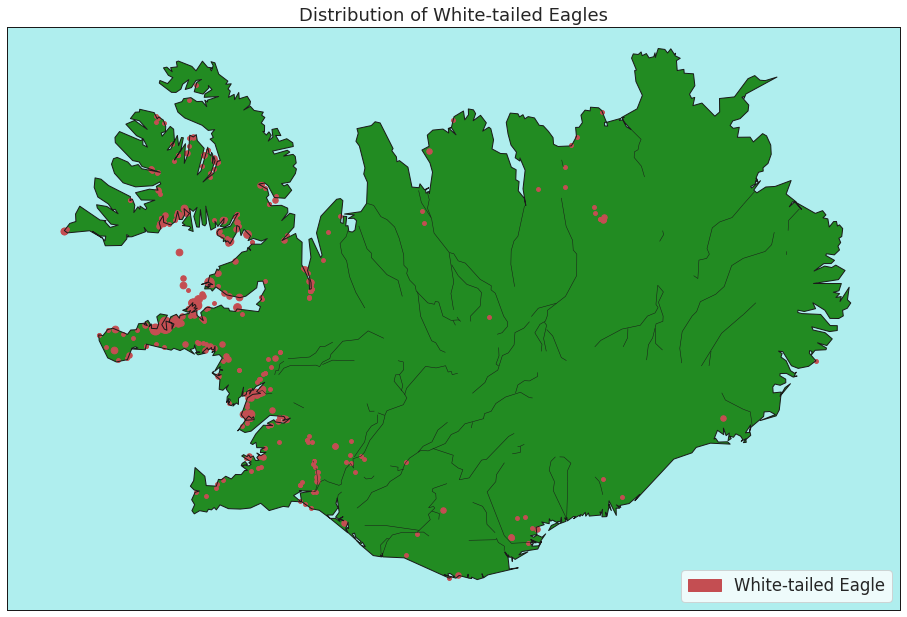

In [117]:
# First, we make a seperate dataframe that only contains the White-Tailed Eagles (Ísl: Haförn)
eagles = birds[birds["vernacularName"] == "White-tailed Eagle"]
# Second, we make a map by calling our helper function, make_map()
map = make_map()
# Third, we plot the location of the Eagles on our map by using plot_birds()
plot_birds(eagles, map)
eagle_patch = mpatches.Patch(color="r", label="White-tailed Eagle")
plt.legend(handles=[eagle_patch], loc="lower right")
plt.title("Distribution of White-tailed Eagles")
plt.show()

### Short-eared Owl

![Short-eared Owl - Author: Sumeet Moghe](images/Short-eared_Owl.jpg)

We can also plot the locations of multiple different species. Here we compare locations of [White-tailed Eagles](https://ebird.org/species/whteag) and [Short-eared Owls](https://ebird.org/species/sheowl):

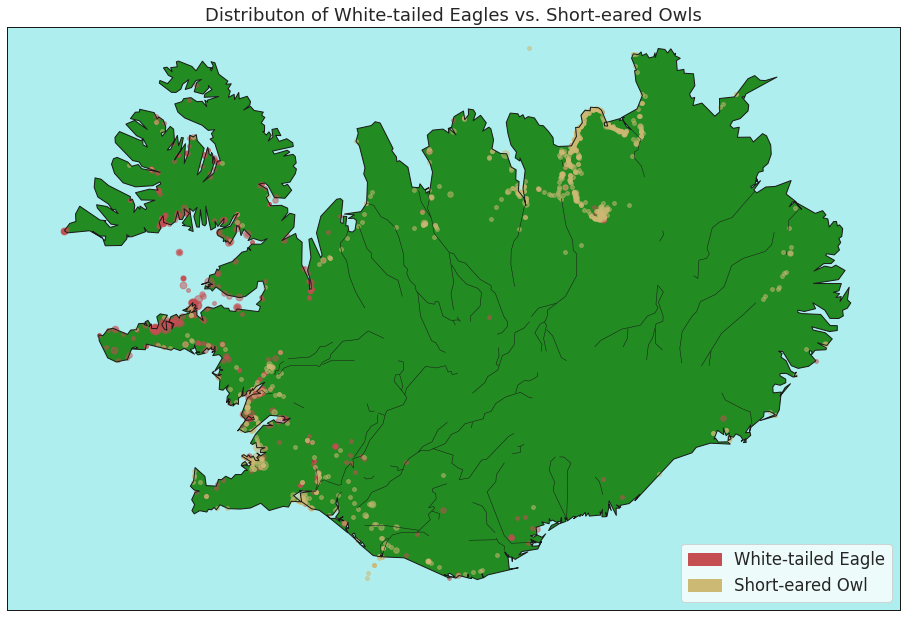

In [118]:
# Dataframe of Short-Eared Owls (Ísl: Brandugla)
shortEaredOwls = birds[birds["vernacularName"] == "Short-eared Owl"]


map = make_map()

# Here we set the alpha level to 0.5 to deal with overlapping markers 
plot_birds(eagles, map, "ro", .5) 
plot_birds(shortEaredOwls, map, "yo", .5)

owl_patch = mpatches.Patch(color="y", label="Short-eared Owl")
plt.legend(handles=[eagle_patch, owl_patch], loc="lower right")
plt.title("Distributon of White-tailed Eagles vs. Short-eared Owls")
plt.show()

### Whooper Swan
![Whooper Swan - Author: Joachim Kohler](images/Whooper_Swan.jpg)

Plotting the locations of [Whooper Swans](https://ebird.org/species/whoswa) yields some interesting results:

The location with the extremely high density of swans in the lower eastern corner is fittingly called Álftafjörður, which is Icelandic for "Swan Fjord".

In [157]:
def monthly_plot(dataframe:pd.DataFrame):
    dataframe = dataframe.sort_values(by=["year", "month", "day"])
    highest = dataframe["individualCount"].max()
    bird_name = dataframe["vernacularName"].iloc[0]
    fig = px.density_mapbox(
        dataframe, 
        lat=dataframe['decimalLatitude'], 
        lon=dataframe['decimalLongitude'], 
        z=dataframe['individualCount'],
        # radius=100,
        zoom=5,
        title=bird_name,
        mapbox_style="stamen-terrain",
        animation_frame=dataframe["month"],
        # animation_frame=dataframe["eventDate"],
        range_color=(1, highest)
    )

    fig.update_layout(
        autosize=False,
        width=1000,
        height=800,
        coloraxis_colorbar_title_text="Count"
        )
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
    fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 1000
    fig.layout.coloraxis.showscale = True   
    fig.layout.sliders[0].pad.t = 10
    fig.layout.updatemenus[0].pad.t= 10
    bird_name = bird_name.replace(" ", "_")           
    fig.write_html("./animations/" + bird_name + ".html")
    fig.show()

## Migration and seasonal differences

Bird occurences are not spread out uniformly through time. The birds you might see in January will most likely differ from the birds you will see in July. 

Many bird species are migratory. Some of them come to Iceland to breed in the summer months, while others choose Iceland as their wintering site.

In this section we will explore how these patterns of bird occurences change throughout time.

In [120]:
# frame         pandas DataFrame
# year_start    year to start counting from (optional)
def make_heatmap(frame, year_start=1900):
    frame = frame[(frame["year"] >= year_start)]
    heatmap_prep = (frame.pivot_table(index=frame['year'],
                                       columns=frame['month'],
                                       values='individualCount', aggfunc=np.sum))
    return sns.heatmap(heatmap_prep, cmap='Reds')

### Atlantic Puffin
![Atlantic Puffin - Author: Richard Bartz](images/Atlantic_Puffin.jpg)

The [Atlantic Puffin](https://ebird.org/species/atlpuf) is by far the most common bird in Iceland with an estimated 2.000.000 breeding pairs and a total of around 7.000.000 birds by autumn.

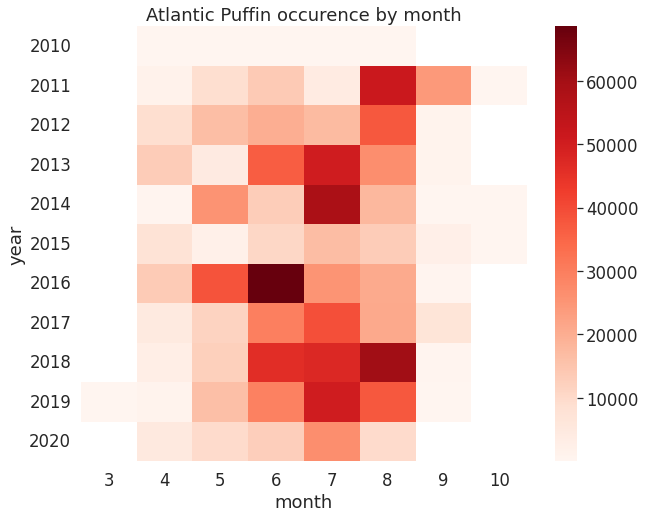

In [142]:
puffins = birds[birds["vernacularName"] == "Atlantic Puffin"]
puffins.head()
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(puffins, 2010)
plt.title("Atlantic Puffin occurence by month")
plt.show()

Note how, despite having such a huge population, the puffins seem to appear out of thin air at the end of spring and completely disappear by the start of autumn.

The reason for this is simple. Atlantic Puffins spend the majority of their life far out on the northern seas. They only return to land to breed.

### Arctic Tern
![Arctic Tern - Author: Andreas Weith](images/Arctic_Tern.jpg)

[Arctic Terns](https://ebird.org/species/arcter) are very commonly seen in Iceland during the summer.

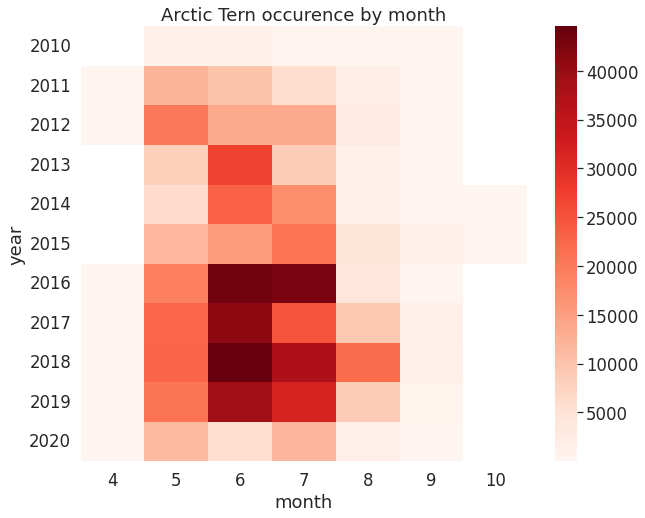

In [149]:
terns = birds[birds["vernacularName"] == "Arctic Tern"]
terns.head()
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(terns, 2010)
plt.title("Arctic Tern occurence by month")
plt.show()

These terns migrate all the way from Antarctica to their breeding grounds in Iceland and back again each year. Their migratory journey is the longest in the animal kingdom, with an average annual round-trip length of about 70,900 km. This allows them to experience two summers; one in the Southern Hemisphere and another in the Northern Hemisphere.

In [152]:
monthly_plot(terns)

### Gray Heron
![Gray Heron - Author: Basile Morin](images/Gray_Heron.jpg)

The [Gray Heron](https://ebird.org/species/graher1) is not endemic to Iceland and is considered [rare](#icelandic-names-and-rarity).

In [ ]:
grayHerons = birds[birds["vernacularName"] == "Gray Heron"]
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(grayHerons)
plt.title("Gray Heron occurence by month")
plt.show()

Here we see an inverse of the occurence patterns we saw in the Atlantic Puffins and Arctic Terns. It seems that the Gray Heron is (mostly) a winter vagrant in Iceland.

### Goldcrest
![Goldcrest - Author: Francis C. Franklin](images/Goldcrest.jpg)

We can use our heatmap function to examine the overall population and breeding status of a species.

[Goldcrests](https://ebird.org/species/goldcr1) are the smallest European birds. They used to be rare vagrants in Iceland but in the last two and a half decades they have colonized the country and is now considered a resident bird.

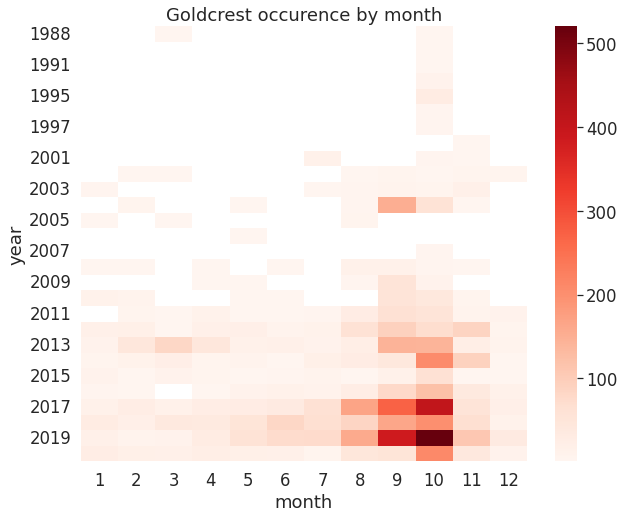

In [154]:
goldcrests = birds[birds["vernacularName"] == "Goldcrest"]
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(goldcrests)
plt.title("Goldcrest occurence by month")
plt.show()

This confirms what has been written about the goldcrest population in Iceland. Goldcrests started appearing in large numbers around 1995 and breeding was confirmed in 1999 (*Róbert Arnar Stefánsson and Sigrún Bjarnadóttir*). The population crashed in the autumn of 2005 but has since bounced back. (*Kristinn Haukur Skarphéðinsson*).

In [158]:
monthly_plot(goldcrests)

## Machine Learning

In [ ]:
# TODO: Remove everything exept year, month, day, decimalLatitude, decimalLongitude, and the y column. Possible y values  = ['genus', 'family']
from sklearn.preprocessing import OrdinalEncoder
y_column_name = 'rare'
data = birds[['year', 'month', 'day', 'decimalLatitude', 'decimalLongitude', 'individualCount', y_column_name]]
# data = pd.get_dummies(data, columns=['genus'])
data = data.astype({"decimalLatitude":'int', "decimalLongitude":'int'}) 
data.drop(data[data.year < 1999].index, inplace=True)
enc = OrdinalEncoder()
data[[y_column_name]] = enc.fit_transform(data[[y_column_name]])
data.head()

In [ ]:
from sklearn.model_selection import train_test_split
def get_training_and_test_data(data, classifier_name, random_state=42, test_size=0.2, norm=False ):
    y = data[classifier_name]
    x = data.loc[:, data.columns != classifier_name]
    return train_test_split(x, y, test_size=test_size, random_state=random_state)


In [ ]:
from imblearn.over_sampling import SMOTE
def get_balanced_train_test_data(data, classifier_name, random_state=42, test_size=0.2, norm=False):
    y = data[classifier_name]
    X = data.loc[:, data.columns != classifier_name]
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X, y)
    return train_test_split(X_res, y_res, test_size=test_size, random_state=random_state)

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier

class ClassifierSwitcher(BaseEstimator):
    def __init__(self, estimator=DecisionTreeClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import naive_bayes
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

In [ ]:
pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('feature_select', SelectKBest()),
    ('clf', ClassifierSwitcher()),
])

feature_select_values = [6, 7, 8]
# feature_select_values = [6]

parameters = [
    # {
    #     'clf__estimator': [DecisionTreeClassifier()],
    #     'variance_threshold__threshold': [0],
    #     'feature_select__k': feature_select_values,
    #     'clf__estimator__max_depth': [None, 10, 20, 30],
    #     'clf__estimator__criterion': ["gini", "entropy"],
    #     'clf__estimator__splitter': ['best','random']
    # },
    # {
    #     'clf__estimator': [naive_bayes.GaussianNB()],
    #     'variance_threshold__threshold': [0],
    #     'feature_select__k': feature_select_values
    # },
    # {
    #     'clf__estimator': [naive_bayes.MultinomialNB()],
    #     'variance_threshold__threshold': [0],
    #     'feature_select__k': feature_select_values
    # },
    # {
    #     'clf__estimator': [RandomForestClassifier()],
    #     'variance_threshold__threshold': [0],
    #     'feature_select__k': feature_select_values,
    #     'clf__estimator__criterion': ["gini", "entropy"],
    #     'clf__estimator__n_estimators': [40, 50, 60, 70, 80],
    #     'clf__estimator__max_depth': [80,90,100,110,120]
    # }
]

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)

# cv=184
# TODO: Split data to train and test
x_train, x_test, y_train, y_test = get_balanced_train_test_data(data, y_column_name)
grid_search.fit(*(data.loc[:, data.columns != y_column_name],data[y_column_name]))
print(f'Best Estimator: {grid_search.best_estimator_}') # Finding the best estimator
clf = grid_search.best_estimator_

selection = SelectKBest(k= grid_search.best_params_["feature_select__k"]).fit(x_train, y_train)
x_train = selection.transform(x_train)
# clf = naive_bayes.MultinomialNB()
# clf.fit(x_train, y_train)
x_test = selection.transform(x_test)
print(f'Classification report: \n{classification_report(y_test, clf.predict(x_test))}')

## References
- Róbert Arnar Stefánsson and Sigrún Bjarnadóttir - 2005. [Útbreiðsla glókolls á Vesturlandi.](https://nsv.is/wp-content/uploads/2021/10/2005_Utbreidsla-glokolls-a-Vesturlandi-Robert-Sigrun-Bliki.pdf) (The distribution of Goldcrest in W-Iceland).
- Kristinn Haukur Skarphéðinsson - 2018. [Glókollur (*Regulus regulus*)](https://www.ni.is/biota/animalia/chordata/aves/passeriformes/glokollur-regulus-regulus)

## Image attributions

[White-tailed Eagle](#white-tailed-eagle)
- Author: Jacob Spinks 
- License: [Creative Commons Attribution 2.0](https://creativecommons.org/licenses/by/2.0/)

[Short-eared Owl](#short-eared-owl) 
- Author: Sumeet Moghe 
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Whooper Swan](#whooper-swan) 
- Author: Joachim Kohler
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Atlantic Puffin](#atlantic-puffin) 
- Author: Richard Bartz
- License: [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

[Arctic Tern](#arctic-tern) 
- Author: Andreas Weith
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Gray Heron](#gray-heron) 
- Author: Basile Morin
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Goldcrest](#goldcrest) 
- Author: Francis C. Franklin
- License: [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/)